<a href="https://colab.research.google.com/github/RAGHVI27/Deep-learning-based-Chronic-Kidney-Disease-Detection/blob/main/CSE_4020_JCOMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

df = pd.read_csv('kidney_disease_1.csv')
numerical_columns = ['age', 'bp', 'sg', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
# remove typos
df.replace('\t?', np.nan, inplace=True)
# Impute missing values in numerical columns with mean
numerical_imputer = SimpleImputer(strategy='mean')
df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing values in categorical columns with mode
categorical_columns = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

df.drop('id', axis=1, inplace=True)
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Standardising numerical features
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

X = df.drop('classification', axis=1)
y = df['classification']
X.fillna(X.mean(), inplace=True)

y = pd.factorize(df['classification'])[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
sfm = SelectFromModel(rf, threshold=0.1)
sfm.fit(X_train, y_train)
X_train = sfm.transform(X_train)
X_test = sfm.transform(X_test)

# Display the feature importance
feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


   Feature  Importance
15     pcv    0.160844
2       sg    0.152819
14    hemo    0.144927
11      sc    0.109856
3       al    0.101521
17      rc    0.099297
19      dm    0.046545
9      bgr    0.038817
12     sod    0.028266
18     htn    0.021082
10      bu    0.016953
0      age    0.015438
16      wc    0.014234
13     pot    0.011575
21   appet    0.009922
1       bp    0.009367
6       pc    0.005056
22      pe    0.004710
4       su    0.004332
5      rbc    0.001748
23     ane    0.001256
7      pcc    0.000979
20     cad    0.000332
8       ba    0.000124


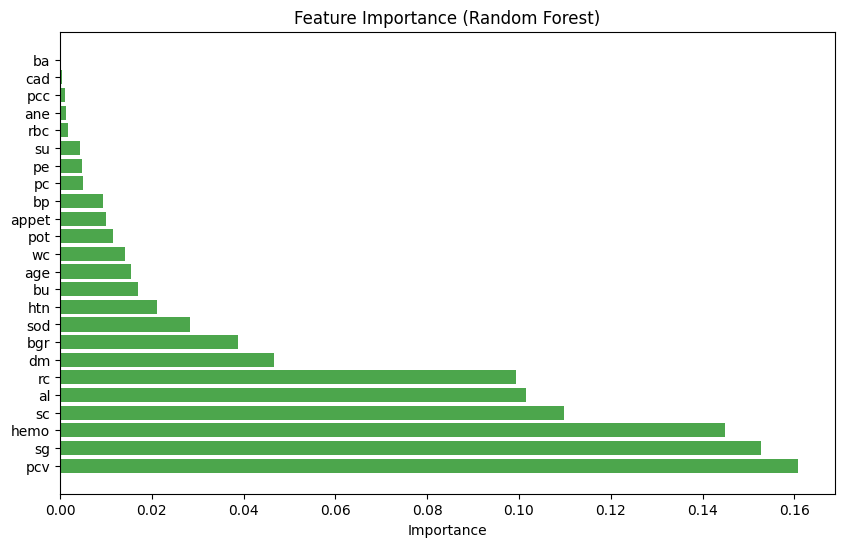

In [2]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='green', alpha=0.7)
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()


In [29]:
print(X_train.shape)
print(X_test.shape)

(320, 5)
(80, 5)


In [3]:
#to start training lstm model
from keras.models import Sequential
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

lstm_output = model.layers[0](X_train)
lstm_output_test = model.layers[0](X_test)
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#accuracy = accuracy_score(y_test, y_pred, average='none', zero_division=1)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)

# Print classification report
print(classification_report(y_test, y_pred))

Epoch 1/10
10/10 [==============================] - 3s 90ms/step - loss: 0.6878 - accuracy: 0.1688 - val_loss: 0.6596 - val_accuracy: 0.0625
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 0.6202 - accuracy: 0.0594 - val_loss: 0.5983 - val_accuracy: 0.1000
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.5284 - accuracy: 0.0750 - val_loss: 0.5319 - val_accuracy: 0.1000
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 0.4342 - accuracy: 0.0688 - val_loss: 0.4547 - val_accuracy: 0.0875
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2760 - accuracy: 0.0688 - val_loss: 0.4024 - val_accuracy: 0.0875
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.1099 - accuracy: 0.0719 - val_loss: 0.3707 - val_accuracy: 0.1125
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: -0.0668 - accuracy: 0.0969 - val_loss: 0.3042 - val_accuracy: 0.1250
Epoch 8/10
1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [4]:
print("NaN values in y_pred:", np.isnan(y_pred).any())
print("Inf values in y_pred:", np.isinf(y_pred).any())


NaN values in y_pred: False
Inf values in y_pred: False


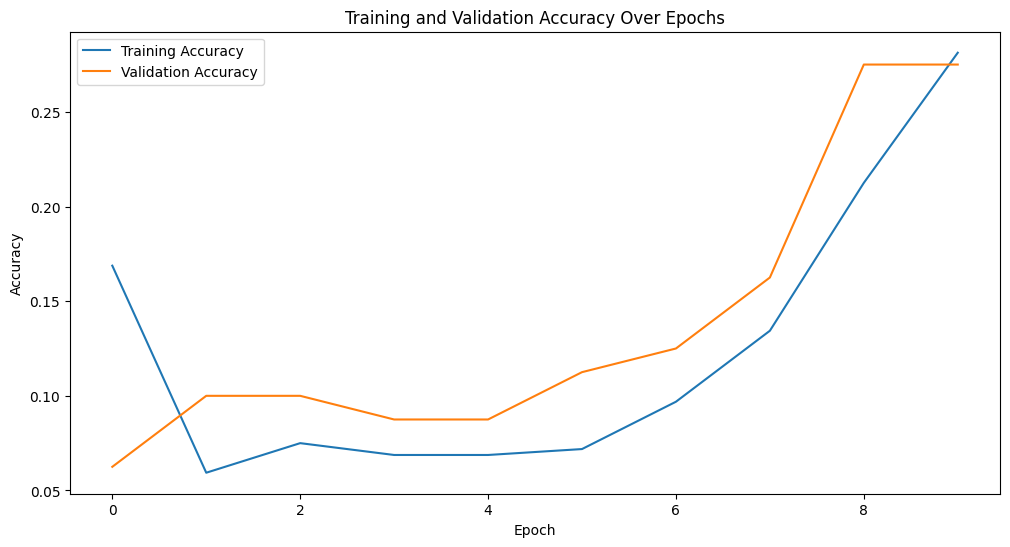

In [5]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# New section

In [9]:
"""
from keras.models import Sequential
from keras.layers import GRU, Dense
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()
# GRU Model
gru_model = Sequential()
gru_model.add(GRU(64, input_shape=(lstm_output.shape[1], 1)))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for GRU
lstm_output_reshaped = lstm_output.reshape(lstm_output.shape[0], lstm_output.shape[1], 1)

history1=gru_model.fit(lstm_output_reshaped, y_train, epochs=10, batch_size=32)
gru_output = gru_model.layers[0](lstm_output_reshaped)

gru_predictions = gru_model.predict(lstm_output_reshaped)
gru_predictions = (gru_predictions > 0.5)

print(classification_report(y_train, gru_predictions))

"""


Epoch 1/10
10/10 [==============================] - 2s 31ms/step - loss: 0.6300 - accuracy: 0.0469
Epoch 2/10
10/10 [==============================] - 0s 33ms/step - loss: 0.5095 - accuracy: 0.0063
Epoch 3/10
10/10 [==============================] - 0s 32ms/step - loss: 0.3604 - accuracy: 0.0063
Epoch 4/10
10/10 [==============================] - 0s 31ms/step - loss: 0.0627 - accuracy: 0.0063
Epoch 5/10
10/10 [==============================] - 0s 31ms/step - loss: -0.2243 - accuracy: 0.0063
Epoch 6/10
10/10 [==============================] - 0s 32ms/step - loss: -0.8060 - accuracy: 0.2625
Epoch 7/10
10/10 [==============================] - 0s 37ms/step - loss: -1.4358 - accuracy: 0.3125
Epoch 8/10
10/10 [==============================] - 0s 33ms/step - loss: -1.8739 - accuracy: 0.3594
Epoch 9/10
10/10 [==============================] - 0s 31ms/step - loss: -2.2437 - accuracy: 0.3938
Epoch 10/10
10/10 [==============================] - 1s 10ms/step
              precision    recall  f1-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
from keras.models import Sequential
from keras.layers import GRU, Dense
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

# GRU Model
gru_model = Sequential()
gru_model.add(GRU(64, input_shape=(lstm_output.shape[1], 1)))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for GRU
lstm_output_reshaped = lstm_output.reshape(lstm_output.shape[0], lstm_output.shape[1], 1)
lstm_output_test_reshaped = lstm_output_test.reshape(lstm_output_test.shape[0], lstm_output_test.shape[1], 1)

history1 = gru_model.fit(lstm_output_reshaped, y_train, epochs=10, batch_size=32, validation_data=(lstm_output_test_reshaped, y_test))

gru_output_train = gru_model.layers[0](lstm_output_reshaped)

gru_predictions_train = gru_model.predict(lstm_output_reshaped)
gru_predictions_train = (gru_predictions_train > 0.5)

# Print classification report for the GRU model on the training set
print("Training Set Classification Report:")
print(classification_report(y_train, gru_predictions_train))

gru_output_test = gru_model.layers[0](lstm_output_test_reshaped)

# Reshape gru_output_test to 3D array
gru_output_test_reshaped = gru_output_test.reshape(gru_output_test.shape[0], gru_output_test.shape[1], 1)

# Get the output of the GRU model on the test set
gru_predictions_test = gru_model.predict(gru_output_test_reshaped)
gru_predictions_test = (gru_predictions_test > 0.5)

# Print classification report for the test set
print("\nTest Set Classification Report:")
print(classification_report(y_test, gru_predictions_test))


Epoch 1/10
10/10 [==============================] - 5s 156ms/step - loss: 0.6488 - accuracy: 0.0281 - val_loss: 0.6254 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 48ms/step - loss: 0.5519 - accuracy: 0.0063 - val_loss: 0.5579 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 52ms/step - loss: 0.4320 - accuracy: 0.0063 - val_loss: 0.5354 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 0s 47ms/step - loss: 0.3644 - accuracy: 0.0063 - val_loss: 0.4531 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 0s 46ms/step - loss: 0.2649 - accuracy: 0.0063 - val_loss: 0.3652 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 53ms/step - loss: -0.0691 - accuracy: 0.0063 - val_loss: 0.0666 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 66ms/step - loss: -0.8223 - accuracy: 0.1781 - val_loss: -0.8569 - val_ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 1s 19ms/step

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.96      0.83        52
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        28

    accuracy                           0.62        80
   macro avg       0.24      0.32      0.28        80
weighted avg       0.47      0.62      0.54        80



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

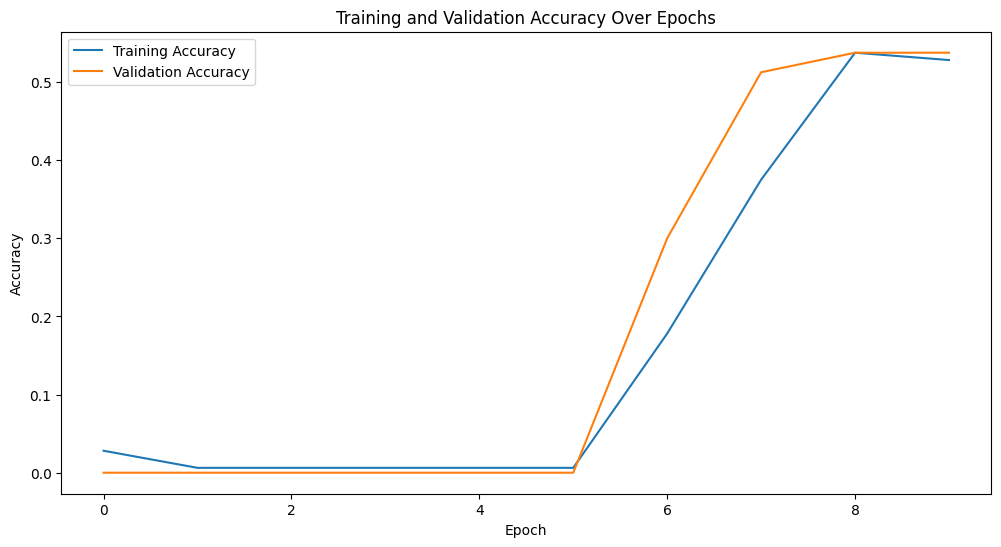

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [8]:
from keras.layers import SimpleRNN

# RNN Model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, input_shape=(gru_output_train.shape[1], 1)))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for RNN input
gru_output_reshaped = gru_output_train.reshape(gru_output_train.shape[0], gru_output_train.shape[1], 1)

# Train the RNN model
history2=rnn_model.fit(gru_output_reshaped, y_train, epochs=10, batch_size=32, validation_data=(gru_output_test_reshaped, y_test))

# Get the output of the RNN model on the training set
rnn_predictions_train = rnn_model.predict(gru_output_reshaped)
rnn_predictions_train = (rnn_predictions_train > 0.5)

# Print classification report for the RNN model on the training set
print("Training Set Classification Report:")
print(classification_report(y_train, rnn_predictions_train))

# Assuming X_test is the original features for the test set
# Reshape gru_output_test to 3D array
gru_output_test_reshaped = gru_output_test.reshape(gru_output_test.shape[0], gru_output_test.shape[1], 1)

# Get the output of the RNN model on the test set
rnn_predictions_test = rnn_model.predict(gru_output_test_reshaped)
rnn_predictions_test = (rnn_predictions_test > 0.5)

# Print classification report for the RNN model on the test set
print("\nTest Set Classification Report:")
print(classification_report(y_test, rnn_predictions_test))


Epoch 1/10
10/10 [==============================] - 1s 39ms/step - loss: 0.6080 - accuracy: 0.4563 - val_loss: 0.4712 - val_accuracy: 0.3625
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2323 - accuracy: 0.4625 - val_loss: 0.1662 - val_accuracy: 0.4500
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: -0.0601 - accuracy: 0.4719 - val_loss: 0.0282 - val_accuracy: 0.4125
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: -0.2547 - accuracy: 0.4594 - val_loss: -0.1061 - val_accuracy: 0.4375
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: -0.4271 - accuracy: 0.4688 - val_loss: -0.2208 - val_accuracy: 0.4375
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: -0.5258 - accuracy: 0.4594 - val_loss: -0.2210 - val_accuracy: 0.3875
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: -0.6071 - accuracy: 0.4437 - val_loss: -0.3582 - val_accuracy: 0.4375
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        52
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        28

    accuracy                           0.44        80
   macro avg       0.33      0.22      0.27        80
weighted avg       0.65      0.44      0.52        80



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

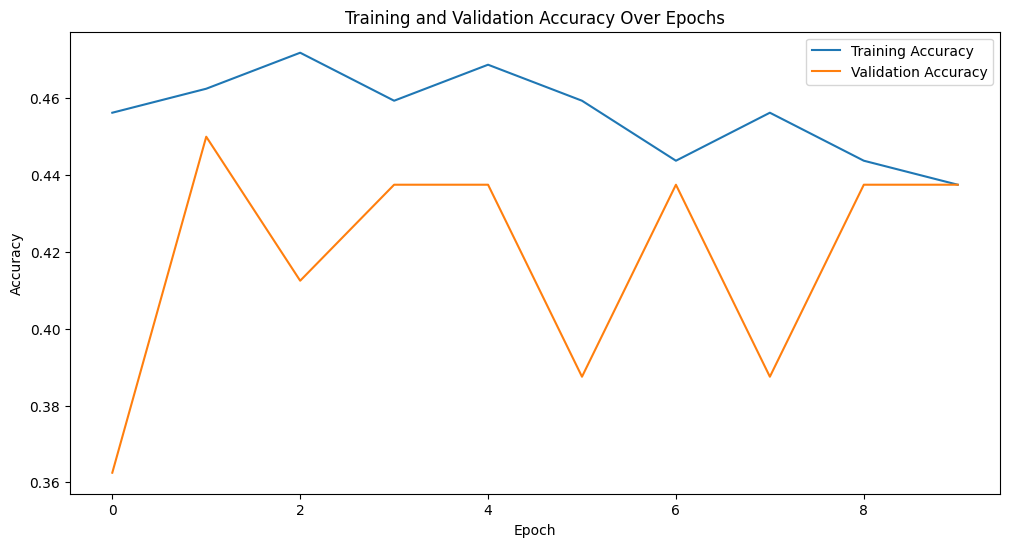

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [34]:
#print(rnn_predictions_test)
print(rnn_predictions_train)

[[False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 

In [20]:
"""
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
# Reshape X_train to 2D array
num_samples, sequence_length, num_features = X_train.shape
X_train_2d = X_train.reshape(num_samples, -1)

# Create a DataFrame
columns = [f'feature_{i}_time_{j}' for i in range(num_features) for j in range(sequence_length)]
df_X_train = pd.DataFrame(X_train_2d, columns=columns)

print(df_X_train)

rnn_predictions_df = pd.DataFrame(rnn_predictions, columns=['rnn_output'])

# Convert rnn_test_predictions_df to a DataFrame
rnn_test_predictions_df = pd.DataFrame(rnn_test_predictions_df, columns=['rnn_output'])

# Combine the RNN output with the original features in the test set
X_test_combined = pd.concat([X_test, rnn_test_predictions_df], axis=1)


     feature_0_time_0  feature_0_time_1  feature_0_time_2  feature_0_time_3  \
0           -2.342354          4.000000          0.143536         -0.580802   
1            1.342766          0.000000         -0.301054         -0.052159   
2            0.421486          1.016949         -0.016517         -1.708574   
3            1.342766          0.000000         -0.318837          0.758426   
4            0.421486          0.000000         -0.407755          0.546969   
..                ...               ...               ...               ...   
315         -1.421074          1.000000          0.054618         -1.074202   
316          0.421486          1.016949          0.552558         -2.413431   
317          1.342766          0.000000         -0.336621          0.511726   
318          0.421486          0.000000         -0.443322          0.265026   
319         -1.421074          0.000000         -0.158785          0.370755   

     feature_0_time_4  
0           -0.885839  
1  

TypeError: ignored

In [ ]:
"""
import pandas as pd

# Reshape X_train to 2D array
num_samples, sequence_length, num_features = X_train.shape
X_train_2d = X_train.reshape(num_samples, -1)

# Create a DataFrame
columns = [f'feature_{i}_time_{j}' for i in range(num_features) for j in range(sequence_length)]
df_X_train = pd.DataFrame(X_train_2d, columns=columns)

# Display the DataFrame
print(df_X_train)
"""

     feature_0_time_0  feature_0_time_1  feature_0_time_2  feature_0_time_3  \
0                 3.0         -2.342354          4.000000          0.143536   
1                18.0          1.342766          0.000000         -0.301054   
2               202.0          0.421486          1.016949         -0.016517   
3               250.0          1.342766          0.000000         -0.318837   
4               274.0          0.421486          0.000000         -0.407755   
..                ...               ...               ...               ...   
315              71.0         -1.421074          1.000000          0.054618   
316             106.0          0.421486          1.016949          0.552558   
317             270.0          1.342766          0.000000         -0.336621   
318             348.0          0.421486          0.000000         -0.443322   
319             102.0         -1.421074          0.000000         -0.158785   

     feature_0_time_4  
0           -0.885839  
1  

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


#num_samples_train, num_features_train = rnn_predictions_train.shape
#rnn_train_predictions_2d = rnn_predictions_train.reshape(num_samples_train, -1)

#num_samples_test, num_features_test = rnn_predictions_test.shape
#rnn_test_predictions_2d = rnn_predictions_test.reshape(num_samples_test, -1)

num_samples_train, num_features_train = gru_output_train.shape
rnn_train_predictions_2d = gru_output_train.reshape(num_samples_train, -1)

# Reshape rnn_predictions_test to 2D array
num_samples_test, num_features_test = gru_output_test.shape
rnn_test_predictions_2d = gru_output_test.reshape(num_samples_test, -1)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
svm = SVC(random_state=42)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(rnn_train_predictions_2d, y_train)

# Predictions on the test set using SVM meta-learner

best_params = grid_search.best_params_
best_kernel = best_params['kernel']
best_C = best_params['C']

best_svm = SVC(kernel=best_kernel, C=best_C, random_state=42)
best_svm.fit(rnn_train_predictions_2d, y_train)

# Make predictions with the best SVM classifier on the test set
y_pred_best_svm = best_svm.predict(rnn_test_predictions_2d)

# Print classification report for the final combined model with the best SVM
print("Best Kernel:", best_kernel)
print("Best C:", best_C)
print(classification_report(y_test, y_pred_best_svm))



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Kernel: linear
Best C: 100
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        52
           2       0.78      1.00      0.88        28

    accuracy                           0.90        80
   macro avg       0.89      0.92      0.90        80
weighted avg       0.92      0.90      0.90        80

